In [59]:
import prettyNEAT as pn
import domain
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
import math
from collections import namedtuple
from torch import nn
import torch
import torchvision
from torchvision import transforms
import pandas as pd
from ribs.visualize import grid_archive_heatmap
import sys
import os

In [2]:
x=np.linspace(-3.9375,3.9375,32)
x= x.repeat(32)
x=x.reshape((32,32))
x=np.stack((x,x.transpose()),axis=2)
r=np.sqrt(np.square(x).sum(axis=2))
x=np.append(x,np.expand_dims(r,2),axis=2)

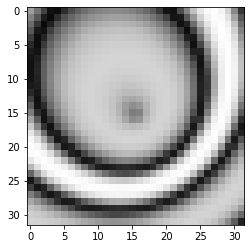

In [3]:
na=[[1,0,0,1,0,0,0,0],
   [1,1,0,1,0,0,0,0],
   [1,0,1,1,0,0,0,0],
   [1,0,0,1,0,0,0,0],
   [0,0,0,0,0,1,0,0],
   [0,0,0,0,1,0,1,0],
   [0,0,0,1,1,1,1,1],
   [0,0,0,1,0,0,0,1]]
im = PIL.Image.open("simple.png")
im1=im.convert("L").resize((32,32))
goal=np.array(im1)/255
goal=np.expand_dims(goal,2)
im.close()
plt.imshow(goal, cmap='Greys_r',vmin=0, vmax=1)

In [4]:
def getMyFitness(game, wVec, aVec, nRep=False,):
    if nRep is False:
        nRep = game.nReps
    wVec[np.isnan(wVec)] = 0
    reward = np.empty(nRep)
    for iRep in range(nRep):
        reward[iRep] = myTestInd(game, wVec, aVec)
    fitness = np.mean(reward)
    return fitness

def myTestInd(game, wVec, aVec):
    myPic = np.empty((32,32,1))      
    for i in range(game.maxEpisodeLength): 
        myPic[i%32][int(i/32)] = pn.act(wVec, aVec, game.nInput, game.nOutput, x[i%32][int(i/32)])
    return (np.square(goal-myPic).sum()-(32*32))/((-32*32))*100

In [5]:
Game = namedtuple('Game', ['env_name', 'time_factor', 'actionSelect',
  'input_size', 'output_size', 'layers', 'i_act', 'h_act',
  'o_act', 'weightCap','noise_bias','output_noise','max_episode_length','in_out_labels'])

game= Game(env_name='cppn',
  actionSelect='all', # all, soft, hard
  input_size=3,
  output_size=1,
  time_factor=0,
  layers=[64, 64],
  i_act=np.full(3,1),
  h_act=[1,3,4,10],
  o_act=np.full(1,6),
  weightCap = 25,
  noise_bias=0.0,
  max_episode_length = 32*32,
  output_noise=[False],
  in_out_labels = ['Pixel Intensity'])

In [78]:
hyp = domain.loadHyp(pFileName='C:\\Users\\mmkir\\Documents\\485\\indeptant study\\prettyNEAT\\config\\default_neat.json')
hyp['alg_nReps']=1
task = domain.GymTask(game, paramOnly=True, nReps=hyp['alg_nReps'])
hyp['ann_nInput']   = task.nInput
hyp['ann_nOutput']  = task.nOutput
hyp['ann_initAct']  = task.activations
hyp['ann_absWCap']  = task.absWCap
hyp['ann_mutSigma'] = task.absWCap * 0.2
hyp['ann_layers']   = task.layers
hyp['ann_actRange'] = task.actRange
hyp['bc_range']=[[0,64],[0,31]]
hyp['map_size']=[32,32]
hyp['maxGen']=10000
neat = pn.Neat(hyp)

In [7]:
neat = pn.Neat(hyp)
for gen in range(hyp['maxGen']):
    pop = neat.ask()
# Get newly evolved individuals from NEAT
    reward = np.empty(len(pop), dtype=np.float64)
    for i in range(len(pop)):
        task = domain.GymTask(game, paramOnly=True, nReps=hyp['alg_nReps'])
        wVec   = pop[i].wMat.flatten()
        aVec   = pop[i].aVec.flatten()
        reward[i] = getMyFitness(task, wVec, aVec) # process it
    neat.tell(reward)
    neat.gen += 1
    my_max=(np.max(reward))
    print(my_max)

76.33282753019428
76.13704793718385
76.2287238917145
76.94939064508381
76.61046497980485
75.87880123606361
76.81502908048263
77.82885622566612


In [25]:
class NeatME(pn.Neat):
    def __init__(self,hyp):
        super().__init__(hyp)
        self.map_elites={}
    def ask(self):
    
        if len(self.pop) == 0:
            self.initPop()      # Initialize population
        else:
            self.probMoo() # Rank population according to objectivess
            self.fill_elites()
            self.gen_with_elites()# Create child population
        return self.pop
    
    def tell(self,reward,bc0,bc1):
        super().tell(reward)
        for i in range(np.shape(reward)[0]):
            #self.pop[i].bc0=bc0[i]
            self.pop[i].bc1=bc1[i]

   
    def fill_elites(self, to_fill=None):
        if to_fill is None:
            to_fill = self.pop
        map_size = self.p["map_size"]
        bc_range = self.p['bc_range']
        for my_ind in to_fill:
            adjusted_bc0=math.ceil((my_ind.bc0-bc_range[0][0])/(bc_range[0][1]-bc_range[0][0])*map_size[0])-1
            adjusted_bc1=math.ceil((my_ind.bc1-bc_range[1][0])/(bc_range[1][1]-bc_range[1][0])*map_size[1])-1
            
            if adjusted_bc0>map_size[0]-1:
                adjusted_bc0 = map_size[0]-1
            elif adjusted_bc0<0:
                adjusted_bc0 =0
                
            if adjusted_bc1>map_size[1]-1:
                adjusted_bc1 = map_size[1]-1
            elif adjusted_bc1<0:
                adjusted_bc1 =0 
                
            key =adjusted_bc0*map_size[1] + adjusted_bc1
            if key in self.map_elites:
                if self.map_elites[key].fitness<my_ind.fitness:
                    self.map_elites[key]=my_ind
            else:
                self.map_elites[key]=my_ind
    
    def gen_with_elites(self):
        new_pop = []
        pop_size = neat.p['popSize']
        numberToCull = int(np.floor(self.p['select_cullRatio'] * len(neat.pop)))
        if numberToCull > 0:
            neat.pop[-numberToCull:] = []
        parentB=np.random.randint(len(neat.pop),size=(pop_size,neat.p['select_tournSize']))
        parentB = np.min(parentB,1)
        a_list=[*self.map_elites.values()]
        for i in range(pop_size):
            parentA=random.choice(a_list)
            if np.random.rand() > self.p['prob_crossover']:
                child, self.innov = parentA.createChild(neat.p,neat.innov,neat.gen)
            else:
                child, self.innov = parentA.createChild(neat.p, neat.innov, neat.gen, mate=neat.pop[parentB[i]])
            child.express()
            new_pop.append(child)
        self.pop=new_pop

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, stride=2, 
            padding=1, output_padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 4, stride=2, 
            padding=1, output_padding=0)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [16]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
encoder.float()
decoder.float()
def train_epoch_den(encoder, decoder, device, archive, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in archive: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = torch.from_numpy(image_batch.pic).squeeze().expand(1,1,-1,-1).float()
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return np.max(train_loss)

def test_encode(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        losses = np.empty(len(dataloader))
        for i, image_batch in enumerate(dataloader):
            # Move tensor to the proper device
            image_batch = torch.from_numpy(image_batch.pic).squeeze().expand(1,1,-1,-1).float()
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            losses[i]=loss_fn(decoded_data.cpu(), image_batch.cpu())
    return losses


Selected device: cpu


In [20]:
def getMyFitnessBc(game, wVec, aVec, ind):
    wVec[np.isnan(wVec)] = 0    
    fitness, bc0 = myTestInd(game, wVec, aVec, ind)
    ind.bc0 = bc0
    return fitness, bc0

def myTestInd(game, wVec, aVec, ind):
    myPic = np.empty((32,32,1))      
    for i in range(game.maxEpisodeLength): 
        myPic[i%32][int(i/32)] = pn.act(wVec, aVec, game.nInput, game.nOutput, x[i%32][int(i/32)])
    ind.pic = myPic
    return (np.square(goal-myPic).sum()-(32*32))/((-32*32))*100, aVec.size

In [76]:
def redo_bc1(inds):
    bc1s = test_encode(encoder, decoder, device, inds, loss_fn)
    for i, ind in enumerate(inds):
        ind.bc1=bc1s[i]
        
def save_elites(my_map, folder, size):
    os.mkdir(folder)
    elite_pic = np.empty(size)
    pdic = {'bc0':[],'bc1':[],'fitness':[]}
    for i in range(size[0]):
        for j in range(size[1]):
            key = i*size[1]+j
            if key in my_map:
                elite_pic[i][j]=my_map[key].fitness
                pdic['bc0'].append(i)
                pdic['bc1'].append(j)
                pdic['fitness'].append(my_map[key].fitness)
            else:
                elite_pic[i][j]=np.nan
    #grid_archive_heatmap(elite_pic,vmin=0, vmax=100)
    #plt.tight_layout()
    #plt.savefig(f'{my_map}/mapOelites.png')
    ar = pd.DataFrame(data=pdic)
    pics=[]
    for i in range(6):
        for j in range(6):
            partion=ar.loc[
                (ar["bc0"]>(j*size[0]/6))&
                (ar["bc0"]<((j+1)*size[0]/6))&
                (ar["bc1"]>(size[1]-(i+1)*size[1]/6))&
                (ar["bc1"]<(size[1]-(i)*size[1]/6))]
            if partion.empty:
                pics.append(na)
            else:
                max_obj=partion[(partion["fitness"].max()==partion["fitness"])]
                a = partion['bc0'].to_numpy()[0]
                b = partion['bc1'].to_numpy()[0]
                max_loc=a*size[1]+b
                pics.append(my_map[max_loc].pic)

    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Best Images")
    for i,p in enumerate(pics):
        plt.subplot(6,6,i+1)
        plt.imshow(p, cmap='Greys_r',vmin=0,vmax=1)
    plt.savefig(str(f'{folder}/results.png'))


In [ ]:
folder= "simple0"
neat = NeatME(hyp)
for gen in range(hyp['maxGen']):
    pop = neat.ask()
# Get newly evolved individuals from NEAT
    reward = np.empty(len(pop), dtype=np.float64)
    bc0 = np.empty(len(pop), dtype=np.float64)
    archive = []
    q = 0
    for i in range(len(pop)):
        task = domain.GymTask(game, paramOnly=True, nReps=hyp['alg_nReps'])
        wVec   = pop[i].wMat.flatten()
        aVec   = pop[i].aVec.flatten()
        reward[i], bc0[i] = getMyFitnessBc(task, wVec, aVec, pop[i]) # process it
    a_len = len(archive)
    #make full archive
    if len(archive)>5000:
        for po in pop:
            archive[q]=po
            q = (q+1)%a_len
    else:
        for po in pop:
            archive.append(po)
    if gen % 500 == 0:
        max_loss = 0
        print('training autoencoder')
        for i in range(250):
            max_loss = train_epoch_den(encoder, decoder, device, archive, loss_fn, optim)
        print('finished autoencoder')
        neat.p['bc_range'][1][1]=max_loss
        v = [*neat.map_elites.values()]
        neat.map_elites={}
        redo_bc1(v)
        redo_bc1(archive)
        neat.fill_elites(v)
        neat.fill_elites(archive)
    neat.tell(reward, bc0, test_encode(encoder, decoder, device, neat.pop, loss_fn))
    neat.gen += 1
    if gen % 25 == 0:
        my_max=(np.max(reward))
        cov = len(neat.map_elites)/(32*32)*100
        print(f'gen:{gen}, max fitness:{my_max:.3f}, archive coverage:{cov}%')
        if my_max > 99.5:
            print(my_max)
            break
save_elites(neat.map_elites, folder, neat.p['map_size'])

training autoencoder
finished autoencoder
gen:0, max fitness:74.983, archive coverage:1.7578125%
gen:25, max fitness:76.633, archive coverage:3.125%
gen:50, max fitness:76.906, archive coverage:3.125%
gen:75, max fitness:76.827, archive coverage:6.0546875%
gen:100, max fitness:77.255, archive coverage:6.25%
gen:125, max fitness:75.858, archive coverage:6.25%
gen:150, max fitness:78.366, archive coverage:6.73828125%
gen:175, max fitness:75.541, archive coverage:9.27734375%
gen:200, max fitness:77.051, archive coverage:9.375%
gen:225, max fitness:76.206, archive coverage:9.375%
gen:250, max fitness:77.778, archive coverage:10.3515625%
gen:275, max fitness:77.044, archive coverage:12.20703125%
gen:300, max fitness:77.044, archive coverage:12.3046875%
gen:325, max fitness:76.542, archive coverage:12.5%
gen:350, max fitness:77.926, archive coverage:12.5%
gen:375, max fitness:76.975, archive coverage:12.98828125%
gen:400, max fitness:78.826, archive coverage:14.2578125%
gen:425, max fitness:

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:500, max fitness:77.427, archive coverage:11.62109375%
gen:525, max fitness:77.182, archive coverage:18.9453125%
gen:550, max fitness:77.685, archive coverage:20.99609375%
gen:575, max fitness:81.112, archive coverage:21.6796875%
gen:600, max fitness:76.403, archive coverage:21.6796875%
gen:625, max fitness:76.759, archive coverage:21.6796875%
gen:650, max fitness:78.380, archive coverage:23.046875%
gen:675, max fitness:76.954, archive coverage:24.12109375%
gen:700, max fitness:75.913, archive coverage:24.8046875%
gen:725, max fitness:76.654, archive coverage:24.90234375%
gen:750, max fitness:81.978, archive coverage:25.0%
gen:775, max fitness:77.109, archive coverage:25.09765625%
gen:800, max fitness:79.384, archive coverage:25.68359375%
gen:825, max fitness:76.261, archive coverage:26.46484375%
gen:850, max fitness:77.845, archive coverage:27.1484375%
gen:875, max fitness:76.901, archive coverage:28.515625%
gen:900, max fitness:78.709, archive coverage:29.1015625%
gen:925, max fi

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:1000, max fitness:76.971, archive coverage:7.2265625%
gen:1025, max fitness:76.832, archive coverage:13.37890625%
gen:1050, max fitness:76.692, archive coverage:18.1640625%
gen:1075, max fitness:74.407, archive coverage:20.8984375%
gen:1100, max fitness:76.135, archive coverage:23.14453125%
gen:1125, max fitness:74.975, archive coverage:25.1953125%
gen:1150, max fitness:78.280, archive coverage:27.05078125%
gen:1175, max fitness:77.604, archive coverage:28.02734375%
gen:1200, max fitness:76.517, archive coverage:29.19921875%
gen:1225, max fitness:76.612, archive coverage:29.98046875%
gen:1250, max fitness:76.416, archive coverage:30.37109375%
gen:1275, max fitness:76.146, archive coverage:30.6640625%
gen:1300, max fitness:76.208, archive coverage:31.640625%
gen:1325, max fitness:75.867, archive coverage:33.203125%
gen:1350, max fitness:75.959, archive coverage:34.27734375%
gen:1375, max fitness:77.680, archive coverage:35.3515625%
gen:1400, max fitness:76.385, archive coverage:35.9

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:1500, max fitness:75.985, archive coverage:21.58203125%
gen:1525, max fitness:77.191, archive coverage:25.09765625%
gen:1550, max fitness:76.274, archive coverage:28.61328125%
gen:1575, max fitness:74.656, archive coverage:30.6640625%
gen:1600, max fitness:76.719, archive coverage:32.421875%
gen:1625, max fitness:77.134, archive coverage:33.984375%
gen:1650, max fitness:75.212, archive coverage:34.765625%
gen:1675, max fitness:75.975, archive coverage:35.7421875%
gen:1700, max fitness:75.204, archive coverage:36.5234375%
gen:1725, max fitness:76.124, archive coverage:37.890625%
gen:1750, max fitness:76.409, archive coverage:38.76953125%
gen:1775, max fitness:75.094, archive coverage:39.0625%
gen:1800, max fitness:77.993, archive coverage:39.453125%
gen:1825, max fitness:76.210, archive coverage:39.55078125%
gen:1850, max fitness:75.170, archive coverage:39.6484375%
gen:1875, max fitness:76.540, archive coverage:39.74609375%
gen:1900, max fitness:75.995, archive coverage:39.84375%
g

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:2000, max fitness:75.846, archive coverage:20.01953125%
gen:2025, max fitness:75.843, archive coverage:31.8359375%
gen:2050, max fitness:80.937, archive coverage:38.37890625%
gen:2075, max fitness:76.493, archive coverage:42.48046875%
gen:2100, max fitness:76.238, archive coverage:43.5546875%
gen:2125, max fitness:77.895, archive coverage:45.5078125%
gen:2150, max fitness:76.677, archive coverage:46.09375%
gen:2175, max fitness:75.260, archive coverage:46.2890625%
gen:2200, max fitness:80.246, archive coverage:46.2890625%
gen:2225, max fitness:77.166, archive coverage:46.484375%
gen:2250, max fitness:76.494, archive coverage:46.77734375%
gen:2275, max fitness:80.298, archive coverage:46.875%
gen:2300, max fitness:75.553, archive coverage:46.97265625%
gen:2325, max fitness:75.917, archive coverage:47.16796875%
gen:2350, max fitness:75.869, archive coverage:47.265625%
gen:2375, max fitness:78.137, archive coverage:47.8515625%
gen:2400, max fitness:76.577, archive coverage:48.14453125

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:2500, max fitness:76.877, archive coverage:28.90625%
gen:2525, max fitness:76.701, archive coverage:37.6953125%
gen:2550, max fitness:75.928, archive coverage:42.67578125%
gen:2575, max fitness:76.972, archive coverage:46.484375%
gen:2600, max fitness:76.198, archive coverage:48.14453125%
gen:2625, max fitness:77.354, archive coverage:49.31640625%
gen:2650, max fitness:79.277, archive coverage:50.29296875%
gen:2675, max fitness:77.464, archive coverage:50.87890625%
gen:2700, max fitness:76.426, archive coverage:51.26953125%
gen:2725, max fitness:77.584, archive coverage:51.953125%
gen:2750, max fitness:76.733, archive coverage:52.63671875%
gen:2775, max fitness:77.565, archive coverage:53.61328125%
gen:2800, max fitness:76.530, archive coverage:53.80859375%
gen:2825, max fitness:76.428, archive coverage:53.80859375%
gen:2850, max fitness:75.701, archive coverage:53.80859375%
gen:2875, max fitness:76.514, archive coverage:54.1015625%
gen:2900, max fitness:78.822, archive coverage:54

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:3000, max fitness:77.959, archive coverage:26.07421875%
gen:3025, max fitness:75.155, archive coverage:33.88671875%
gen:3050, max fitness:75.768, archive coverage:37.40234375%
gen:3075, max fitness:76.338, archive coverage:40.0390625%
gen:3100, max fitness:76.932, archive coverage:40.8203125%
gen:3125, max fitness:76.770, archive coverage:41.9921875%
gen:3150, max fitness:76.426, archive coverage:42.48046875%
gen:3175, max fitness:76.411, archive coverage:43.26171875%
gen:3200, max fitness:78.745, archive coverage:43.84765625%
gen:3225, max fitness:76.690, archive coverage:44.04296875%
gen:3250, max fitness:80.152, archive coverage:44.53125%
gen:3275, max fitness:76.240, archive coverage:44.921875%
gen:3300, max fitness:75.935, archive coverage:45.1171875%
gen:3325, max fitness:77.667, archive coverage:45.60546875%
gen:3350, max fitness:80.971, archive coverage:45.99609375%
gen:3375, max fitness:79.024, archive coverage:46.6796875%
gen:3400, max fitness:76.855, archive coverage:46.

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:3500, max fitness:78.100, archive coverage:29.58984375%
gen:3525, max fitness:76.159, archive coverage:45.60546875%
gen:3550, max fitness:77.751, archive coverage:54.19921875%
gen:3575, max fitness:78.267, archive coverage:59.1796875%
gen:3600, max fitness:82.702, archive coverage:62.79296875%
gen:3625, max fitness:76.452, archive coverage:64.6484375%
gen:3650, max fitness:75.573, archive coverage:66.30859375%
gen:3675, max fitness:76.217, archive coverage:68.26171875%
gen:3700, max fitness:76.523, archive coverage:69.140625%
gen:3725, max fitness:77.726, archive coverage:69.62890625%
gen:3750, max fitness:76.358, archive coverage:70.41015625%
gen:3775, max fitness:77.322, archive coverage:70.703125%
gen:3800, max fitness:76.760, archive coverage:70.8984375%
gen:3825, max fitness:76.544, archive coverage:71.09375%
gen:3850, max fitness:77.937, archive coverage:71.2890625%
gen:3875, max fitness:76.397, archive coverage:71.38671875%
gen:3900, max fitness:78.592, archive coverage:71.5

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:4000, max fitness:75.846, archive coverage:27.1484375%
gen:4025, max fitness:76.321, archive coverage:38.28125%
gen:4050, max fitness:76.950, archive coverage:45.5078125%
gen:4075, max fitness:79.462, archive coverage:50.9765625%
gen:4100, max fitness:74.963, archive coverage:54.58984375%
gen:4125, max fitness:76.323, archive coverage:56.25%
gen:4150, max fitness:76.640, archive coverage:58.88671875%
gen:4175, max fitness:76.639, archive coverage:59.5703125%
gen:4200, max fitness:76.431, archive coverage:60.05859375%
gen:4225, max fitness:76.848, archive coverage:60.546875%
gen:4250, max fitness:76.634, archive coverage:60.7421875%
gen:4275, max fitness:76.867, archive coverage:61.23046875%
gen:4300, max fitness:75.146, archive coverage:61.71875%
gen:4325, max fitness:79.448, archive coverage:61.81640625%
gen:4350, max fitness:77.857, archive coverage:62.01171875%
gen:4375, max fitness:76.299, archive coverage:62.20703125%
gen:4400, max fitness:82.990, archive coverage:62.3046875%


<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:4500, max fitness:75.667, archive coverage:41.796875%
gen:4525, max fitness:78.009, archive coverage:51.7578125%
gen:4550, max fitness:77.677, archive coverage:57.71484375%
gen:4575, max fitness:75.969, archive coverage:62.01171875%
gen:4600, max fitness:75.928, archive coverage:64.6484375%
gen:4625, max fitness:76.477, archive coverage:67.1875%
gen:4650, max fitness:76.986, archive coverage:68.84765625%
gen:4675, max fitness:75.702, archive coverage:69.04296875%
gen:4700, max fitness:76.771, archive coverage:69.82421875%
gen:4725, max fitness:76.267, archive coverage:70.703125%
gen:4750, max fitness:75.974, archive coverage:70.8984375%
gen:4775, max fitness:84.059, archive coverage:71.19140625%
gen:4800, max fitness:78.502, archive coverage:71.58203125%
gen:4825, max fitness:76.444, archive coverage:71.6796875%
gen:4850, max fitness:77.013, archive coverage:71.77734375%
gen:4875, max fitness:76.747, archive coverage:71.875%
gen:4900, max fitness:87.587, archive coverage:71.9726562

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:5000, max fitness:80.630, archive coverage:47.265625%
gen:5025, max fitness:76.972, archive coverage:57.6171875%
gen:5050, max fitness:79.601, archive coverage:62.20703125%
gen:5075, max fitness:76.422, archive coverage:66.50390625%
gen:5100, max fitness:75.408, archive coverage:68.359375%
gen:5125, max fitness:75.627, archive coverage:70.80078125%
gen:5150, max fitness:78.030, archive coverage:72.265625%
gen:5175, max fitness:76.487, archive coverage:73.14453125%
gen:5200, max fitness:78.816, archive coverage:73.828125%
gen:5225, max fitness:77.315, archive coverage:74.12109375%
gen:5250, max fitness:75.839, archive coverage:74.4140625%
gen:5275, max fitness:77.291, archive coverage:74.609375%
gen:5300, max fitness:76.319, archive coverage:74.609375%
gen:5325, max fitness:78.467, archive coverage:74.90234375%
gen:5350, max fitness:75.488, archive coverage:75.1953125%
gen:5375, max fitness:76.325, archive coverage:75.1953125%
gen:5400, max fitness:79.837, archive coverage:75.292968

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:5500, max fitness:79.317, archive coverage:45.1171875%
gen:5525, max fitness:76.153, archive coverage:51.85546875%
gen:5550, max fitness:77.243, archive coverage:56.8359375%
gen:5575, max fitness:76.523, archive coverage:60.83984375%
gen:5600, max fitness:75.742, archive coverage:63.671875%
gen:5625, max fitness:76.900, archive coverage:65.625%
gen:5650, max fitness:76.875, archive coverage:67.08984375%
gen:5675, max fitness:76.669, archive coverage:68.1640625%
gen:5700, max fitness:77.984, archive coverage:68.65234375%
gen:5725, max fitness:82.180, archive coverage:69.23828125%
gen:5750, max fitness:77.159, archive coverage:70.3125%
gen:5775, max fitness:76.645, archive coverage:70.703125%
gen:5800, max fitness:79.275, archive coverage:71.09375%
gen:5825, max fitness:77.689, archive coverage:71.6796875%
gen:5850, max fitness:77.228, archive coverage:71.97265625%
gen:5875, max fitness:75.484, archive coverage:72.16796875%
gen:5900, max fitness:77.320, archive coverage:72.265625%
ge

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:6000, max fitness:76.290, archive coverage:37.59765625%
gen:6025, max fitness:75.970, archive coverage:45.8984375%
gen:6050, max fitness:77.273, archive coverage:51.07421875%
gen:6075, max fitness:79.202, archive coverage:54.98046875%
gen:6100, max fitness:76.555, archive coverage:58.10546875%
gen:6125, max fitness:77.005, archive coverage:59.86328125%
gen:6150, max fitness:77.206, archive coverage:60.9375%
gen:6175, max fitness:75.842, archive coverage:61.42578125%
gen:6200, max fitness:76.426, archive coverage:62.20703125%
gen:6225, max fitness:76.460, archive coverage:62.79296875%
gen:6250, max fitness:77.707, archive coverage:63.4765625%
gen:6275, max fitness:76.780, archive coverage:63.76953125%
gen:6300, max fitness:83.900, archive coverage:64.0625%
gen:6325, max fitness:75.380, archive coverage:64.453125%
gen:6350, max fitness:77.088, archive coverage:65.33203125%
gen:6375, max fitness:76.545, archive coverage:66.015625%
gen:6400, max fitness:78.399, archive coverage:66.5039

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:6500, max fitness:82.165, archive coverage:32.71484375%
gen:6525, max fitness:78.337, archive coverage:41.015625%
gen:6550, max fitness:75.471, archive coverage:45.60546875%
gen:6575, max fitness:76.779, archive coverage:50.0%
gen:6600, max fitness:86.009, archive coverage:53.125%
gen:6625, max fitness:76.487, archive coverage:56.15234375%
gen:6650, max fitness:82.701, archive coverage:57.6171875%
gen:6675, max fitness:77.479, archive coverage:59.1796875%
gen:6700, max fitness:77.499, archive coverage:60.15625%
gen:6725, max fitness:76.400, archive coverage:61.328125%
gen:6750, max fitness:77.266, archive coverage:62.20703125%
gen:6775, max fitness:77.063, archive coverage:62.890625%
gen:6800, max fitness:77.030, archive coverage:63.4765625%
gen:6825, max fitness:77.418, archive coverage:64.0625%
gen:6850, max fitness:77.175, archive coverage:64.55078125%
gen:6875, max fitness:81.040, archive coverage:65.13671875%
gen:6900, max fitness:76.489, archive coverage:65.4296875%
gen:6925,

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:7000, max fitness:78.273, archive coverage:36.42578125%
gen:7025, max fitness:77.050, archive coverage:44.921875%
gen:7050, max fitness:80.113, archive coverage:53.61328125%
gen:7075, max fitness:76.721, archive coverage:60.05859375%
gen:7100, max fitness:76.951, archive coverage:63.671875%
gen:7125, max fitness:77.174, archive coverage:65.8203125%
gen:7150, max fitness:78.257, archive coverage:67.96875%
gen:7175, max fitness:76.169, archive coverage:68.9453125%
gen:7200, max fitness:76.657, archive coverage:69.43359375%
gen:7225, max fitness:77.658, archive coverage:69.82421875%
gen:7250, max fitness:76.596, archive coverage:70.703125%
gen:7275, max fitness:85.905, archive coverage:70.8984375%
gen:7300, max fitness:75.792, archive coverage:71.58203125%
gen:7325, max fitness:76.098, archive coverage:71.77734375%
gen:7350, max fitness:76.527, archive coverage:71.875%
gen:7375, max fitness:77.410, archive coverage:72.265625%
gen:7400, max fitness:78.001, archive coverage:72.36328125%

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:7500, max fitness:76.726, archive coverage:37.20703125%
gen:7525, max fitness:77.160, archive coverage:45.1171875%
gen:7550, max fitness:76.452, archive coverage:50.390625%
gen:7575, max fitness:77.148, archive coverage:54.78515625%
gen:7600, max fitness:76.632, archive coverage:57.71484375%
gen:7625, max fitness:76.380, archive coverage:59.86328125%
gen:7650, max fitness:77.355, archive coverage:61.5234375%
gen:7675, max fitness:76.810, archive coverage:62.40234375%
gen:7700, max fitness:77.225, archive coverage:63.18359375%
gen:7725, max fitness:77.126, archive coverage:63.8671875%
gen:7750, max fitness:76.939, archive coverage:64.55078125%
gen:7775, max fitness:77.116, archive coverage:65.234375%
gen:7800, max fitness:76.879, archive coverage:65.72265625%
gen:7825, max fitness:76.711, archive coverage:66.11328125%
gen:7850, max fitness:76.625, archive coverage:66.30859375%
gen:7875, max fitness:76.560, archive coverage:67.1875%
gen:7900, max fitness:75.861, archive coverage:67.7

<ipython-input-25-bf94dec6fd4a>:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.map_elites[key].fitness<my_ind.fitness:


gen:8000, max fitness:76.901, archive coverage:42.96875%
gen:8025, max fitness:76.027, archive coverage:54.6875%
gen:8050, max fitness:77.455, archive coverage:62.59765625%
